In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import imageio.v2 as imageio

import skimage
from itertools import chain
from sklearn import preprocessing

In [2]:
!kaggle datasets download -d fournierp/captcha-version-2-images
with zipfile.ZipFile("captcha-version-2-images.zip", 'r') as zip_ref:
    zip_ref.extractall("data")
shutil.rmtree("data/samples/samples")
datadir = os.path.join(*[os.getcwd(), "data", "samples"])

captcha-version-2-images.zip: Skipping, found more recently modified local copy (use --force to force download)


PermissionError: [Errno 13] Permission denied: 'data/samples/226md.png'

# DATA GENERATION

In [1]:
alphabet_all = list('qwertyupasdfghjkzxcvbnm23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('qwertyupasdfghjkzxcvbnm23456789')#QWERTYUIOPLKJHGFDSAZXCVBNM') 
prev_alpha = ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y'] # provided alphabet
num_alphabet = len(prev_alpha)
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(prev_alpha, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')
     

In [ ]:
NUM_OF_LETTERS = 5
IMG_ROW, IMG_COLS = 50, 200

# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [ ]:
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, prev_alpha.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:


if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 10000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [ ]:
DATA_PATH = DATA_PATH+'/data'

In [ ]:
for file in os.listdir(DATA_PATH): # limit the image names to 5 characters which create the CAPTCHA text
    src = DATA_PATH + '/' + file
    dst = DATA_PATH + '/' + file[:5] + '.png'
    os.rename(src, dst)

# DATALOADER

In [2]:
datadir = os.path.join(*[os.getcwd(), "data", "samples"])
datanames = os.listdir(datadir)
jpeg = ([img[:-4] for img in datanames if img[-4:]==".jpg"])
png = ([img[:-4] for img in datanames if img[-4:]==".png"])

In [37]:
class Captcha_Dataset(Dataset):
    def __init__(self, datadir, transform=None, preload=True, img_ext=['.png'], mode="train", split_rate=0.8, seed=0):
        self.datadir = datadir
        self.img_ext = img_ext
        self.preload = preload
        
        self.mode = mode
        self.split_rate = split_rate
        self.seed = 0
        
        if self.preload:
            data_list = os.listdir(self.datadir)
            self.data = []
            self.chars = []
            for im_name in os.listdir(self.datadir):
                if im_name[-4:] in self.img_ext:
                    img = imageio.imread(os.path.join(self.datadir, im_name))
                    if len(img.shape) == 3 and img.shape[-1]==3:
                        #img = skimage.color.rgba2rgb(img) # RGBA -> RGB
                        img = skimage.color.rgb2gray(img) # RGB -> Gray
                    if len(img.shape) == 2:
                        img = img
                    label = im_name[:-4]
                    label = list(label)
                    self.data.append((img, label))
            self.characters = list(set(chain.from_iterable((label) for _, label in self.data)))
            self.characters.sort()
            self.class_dict = dict(zip(self.characters, np.arange(len(self.characters))+1))
            self.inv_class_fict = {v: k for k,v in self.class_dict.items()}
            self.data = [(val,list(map(self.class_dict.get, labl))) for val,labl in self.data]
            # print(len(self.data))
            
            if mode=="train":
                self.data = self.data[:int(self.split_rate*len(self.data))]
            elif mode=="val":
                self.data = self.data[int(self.split_rate*len(self.data)):]
                
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        # y=0
        x = torch.Tensor(x).unsqueeze(0)
        y = torch.Tensor(y)
        
        # y_letters = list(y) # Split word to letters
        
        
        if self.transform:
            pass
        return (x, y)
    
    def size(self):#ok
        for i in self.data:
            print(i[0].shape)

In [4]:
dataset_train = Captcha_Dataset(datadir=datadir, mode="train")
dataloader_train = DataLoader(dataset=dataset_train, batch_size=256, shuffle=True)

In [18]:
x_batch, y_batch = next(iter(dataloader_train))

torch.Size([50, 200])


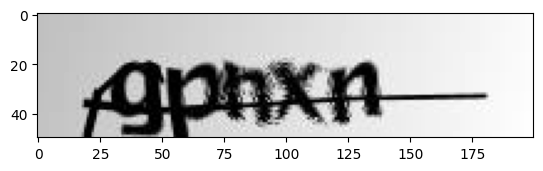

In [19]:
%matplotlib inline
print(x_batch[0,0].shape)
plt.imshow(x_batch[0,0], cmap=plt.cm.gray)
plt.show()

In [5]:
class Captcha_Model(nn.Module):
    def __init__(self, num_channel=1, char=dataset_train.characters):
        super(Captcha_Model, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(1536, 256)
        self.gru = nn.GRU(256, 128, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.linear2 = nn.Linear(256, len(char) + 1)
    def forward(self, img):
        # print(img.size())
        x = F.relu(self.conv1(img))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x =  x.reshape(x.size(0), -1, x.size(-1))
        x = x.permute(0, 2, 1)
        x = self.linear1(x)
        x, _ = self.gru(x)
        x = self.linear2(x)
        x = x.permute(1, 0, 2)
        return x

In [54]:
# Decoding 
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    final = "".join(fin).replace("-", "")
    return final


def decode_predictions(preds, encoder=dataset_train.inv_class_fict):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    last_added = None
    last_char = None
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            if k == 0:
                temp.append("§")
                last_char = "§"
            else:
                p = encoder[k]
                if last_char == "§" and last_added == p:
                    temp.append("-")
                temp.append(p)
                last_added = p
                last_char = p
        tp = "".join(temp).replace("§", "")
        cap_preds.append(remove_duplicates(tp))
    return cap_preds
    
def eval(model, dataloader_test):    
    model.eval()
    predict = []
    gt = []
    imgs = []
    with torch.no_grad():
        for x, y in dataloader_test:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            f = decode_predictions(y_pred, dataloader_test.dataset.inv_class_fict)
            predict.extend(f)
            for k in range(y.size(0)):
                s = "".join(dataloader_test.dataset.inv_class_fict[i.item()] for i in y[k])
                gt.append(s)
                imgs.append(x[k].cpu().numpy())
    return predict, gt, imgs    

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cap = Captcha_Model().to(device)

In [27]:
optimizer = torch.optim.Adam(cap.parameters(), lr=3e-4)
loss_func = nn.CTCLoss(reduction='sum', blank=0)
loss_array = []
acc_array = []
epoch = 1000
for ep in range(epoch):
    cap.train()
    loss_overall = 0.0

        
    predict = []
    gt = []
    imgs = []
    for x, y in dataloader_train:
        #print(x.shape)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = cap(x)
        #print((y_pred.shape))
        y_pred = F.log_softmax(y_pred, 2)
        # print((y_pred.shape))
        inp_len = torch.full(size=(x.size(0),), fill_value=y_pred.size(0), dtype=torch.int32)
        target_len = torch.full(size=(x.size(0),), fill_value=y.size(1), dtype=torch.int32)
        loss = loss_func(y_pred, y, inp_len, target_len)
        loss.backward()
        optimizer.step()
        loss_overall += loss.item()
    loss_array.append(loss_overall/len(dataloader_train.dataset))

    predict, gt, imgs = eval(cap, dataloader_train)
    pos = np.sum([p==g for p, g in zip(predict, gt)])
    acc_array.append(pos/len(predict))

    if ep%10==0 or ep==epoch-1:
        print("Epoch: {}, Loss: {}".format(ep, loss_overall/len(dataloader_train.dataset))) 
        print("Train Accuracy: ", pos/len(predict))
    # if ep%100==0:
    #     optimizer = torch.optim.Adam(cap.parameters(), lr=1e-4) # Resetting Momentum

Epoch: 0, Loss: 113.28473311204176
Train Accuracy:  0.0
Epoch: 10, Loss: 16.306844564584587
Train Accuracy:  0.0
Epoch: 20, Loss: 16.279873481163612
Train Accuracy:  0.0
Epoch: 30, Loss: 16.27148408156175
Train Accuracy:  0.0
Epoch: 40, Loss: 16.261285635141228
Train Accuracy:  0.0
Epoch: 50, Loss: 16.257974331195538
Train Accuracy:  0.0
Epoch: 60, Loss: 16.24690187894381
Train Accuracy:  0.0
Epoch: 70, Loss: 16.229339306171124
Train Accuracy:  0.0
Epoch: 80, Loss: 16.214198919442985
Train Accuracy:  0.0
Epoch: 90, Loss: 16.185049350445087
Train Accuracy:  0.0
Epoch: 100, Loss: 16.148270093477688
Train Accuracy:  0.0
Epoch: 110, Loss: 16.106468200683594
Train Accuracy:  0.0
Epoch: 120, Loss: 16.084139603834885
Train Accuracy:  0.0
Epoch: 130, Loss: 16.01508331298828
Train Accuracy:  0.0
Epoch: 140, Loss: 15.968605334942158
Train Accuracy:  0.0
Epoch: 150, Loss: 15.934715857872597
Train Accuracy:  0.0
Epoch: 160, Loss: 15.913299853985126
Train Accuracy:  0.0
Epoch: 170, Loss: 15.8686926

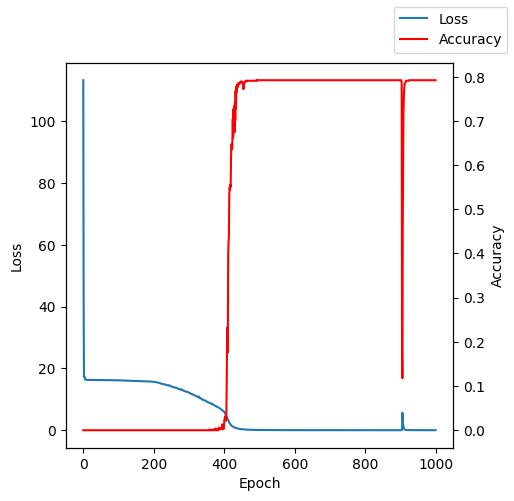

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(loss_array, label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

axs = ax.twinx()
axs.plot(acc_array, label="Accuracy", color="red")
axs.set_ylabel("Accuracy")
fig.legend()
plt.show()

In [5]:
# Eval Clean
datadir = os.path.join(*[os.getcwd(), "data", "samples"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=256, shuffle=False)
predict, gt, imgs = eval(cap, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))
print(f"True pred:{pos}, Total pred:{len(predict)}")

NameError: name 'cap' is not defined

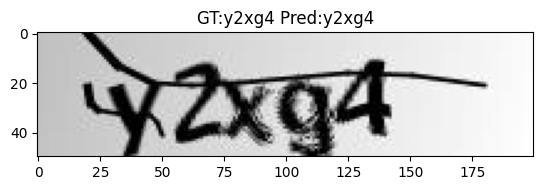

In [68]:
k = 1
plt.imshow(imgs[k][0], cmap=plt.cm.gray)
plt.title( f"GT:{ gt[k]} Pred:{predict[k]}");

In [41]:
torch.save(cap.state_dict(), "captcha_model.pth")

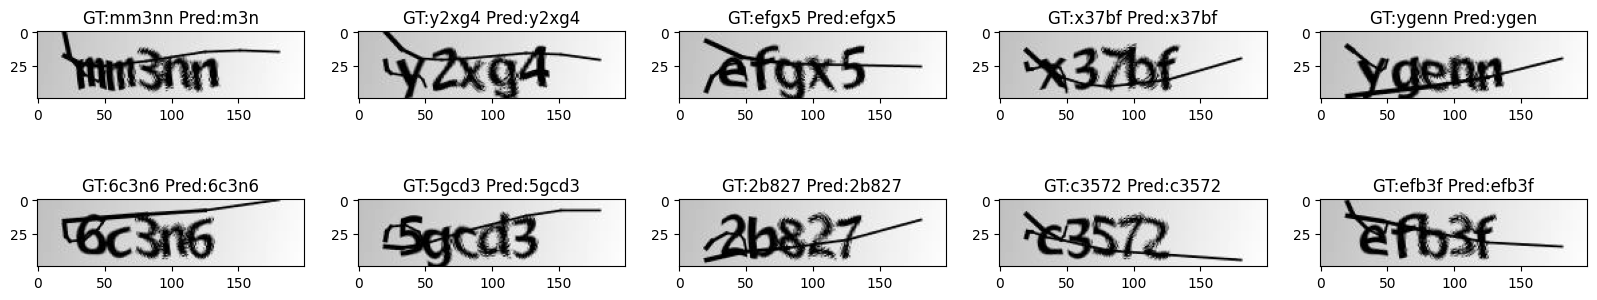

In [56]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(10):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")

# CAPTCHA TEXT WITH NOISY IMAGES

The initial results belong to the model trained with clean samples.

In [57]:
# Eval SP 5
datadir = os.path.join(*[os.getcwd(), "data_noisy", "sp_samples_a05"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.0


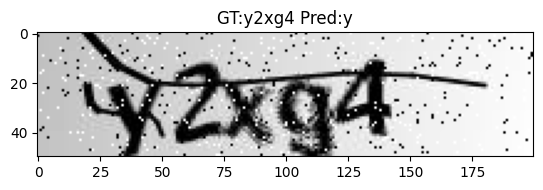

In [58]:
k = 1
plt.imshow(imgs[k][0], cmap=plt.cm.gray)
plt.title( f"GT:{ gt[k]} Pred:{predict[k]}");

In [59]:
# Eval Gauss 1
datadir = os.path.join(*[os.getcwd(), "data_noisy", "gauss_samples_m0_v01"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.0


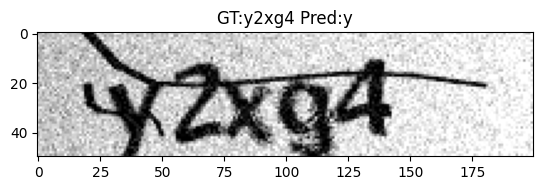

In [60]:
k = 1
plt.imshow(imgs[k][0], cmap=plt.cm.gray)
plt.title( f"GT:{ gt[k]} Pred:{predict[k]}");

In [63]:
# Eval Gauss 10
datadir = os.path.join(*[os.getcwd(), "data_noisy", "gauss_samples_m0_v10"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.0


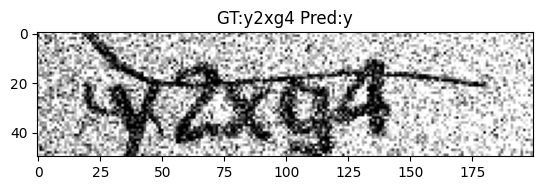

In [64]:
k = 1
plt.imshow(imgs[k][0], cmap=plt.cm.gray)
plt.title( f"GT:{ gt[k]} Pred:{predict[k]}");

In [65]:
# Eval Sp 20
datadir = os.path.join(*[os.getcwd(), "data_noisy", "sp_samples_a20"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.0


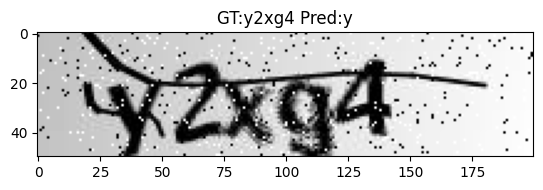

In [66]:
k = 1
plt.imshow(imgs[k][0], cmap=plt.cm.gray)
plt.title( f"GT:{ gt[k]} Pred:{predict[k]}");

After the model is not showing any success with noisy CAPTCHA images, a CRNN model is trained with a new dataset consisting clean samples, sample with salt and pepper noise and samples containing Gaussian noise.

In [41]:
datadir_sp = os.path.join(*[os.getcwd(), "data_noisy", "sp_samples_a20"])
datadir_gauss = os.path.join(*[os.getcwd(), "data_noisy", "gauss_samples_m0_v10"])
datadir_normal = os.path.join(*[os.getcwd(), "train", "data"])
dataset_train = Captcha_Dataset(datadir=datadir_normal, mode="train")
dataset_train_sp = Captcha_Dataset(datadir=datadir_sp, mode="train")
dataset_train_gauss = Captcha_Dataset(datadir=datadir_gauss, mode="train")
train_dev_set = torch.utils.data.ConcatDataset([dataset_train, dataset_train_sp, dataset_train_gauss])
train_dev_set.inv_class_fict = dataset_train.inv_class_fict
dataloader_train_all = DataLoader(dataset=train_dev_set, batch_size=512, shuffle=True)

In [39]:
dataset_train[0][0].shape

torch.Size([1, 50, 200])

In [44]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
cap_noise = Captcha_Model().to(device)

optimizer = torch.optim.Adam(cap_noise.parameters(), lr=3e-4)
loss_func = nn.CTCLoss(reduction='sum', blank=0)
loss_array = []
acc_array = []
epoch = 250
for ep in range(epoch):
    cap_noise.train()
    loss_overall = 0.0

        
    predict = []
    gt = []
    imgs = []
    for x, y in dataloader_train_all:
        #print(x.shape)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = cap_noise(x)
        #print((y_pred.shape))
        y_pred = F.log_softmax(y_pred, 2)
        # print((y_pred.shape))
        inp_len = torch.full(size=(x.size(0),), fill_value=y_pred.size(0), dtype=torch.int32)
        target_len = torch.full(size=(x.size(0),), fill_value=y.size(1), dtype=torch.int32)
        loss = loss_func(y_pred, y, inp_len, target_len)
        loss.backward()
        optimizer.step()
        loss_overall += loss.item()
    loss_array.append(loss_overall/len(dataloader_train_all.dataset))

    predict, gt, imgs = eval(cap_noise, dataloader_train_all)
    pos = np.sum([p==g for p, g in zip(predict, gt)])
    acc_array.append(pos/len(predict))

    if ep%1==0 or ep==epoch-1:
        print("Epoch: {}, Loss: {}".format(ep, loss_overall/len(dataloader_train_all.dataset))) 
        print("Train Accuracy: ", pos/len(predict))
    # if ep%100==0:
    #     optimizer = torch.optim.Adam(cap.parameters(), lr=1e-4) # Resetting Momentum

Epoch: 0, Loss: 26.86289354278814
Train Accuracy:  0.0
Epoch: 1, Loss: 16.41006478386199
Train Accuracy:  0.0
Epoch: 2, Loss: 16.39621399058223
Train Accuracy:  0.0
Epoch: 3, Loss: 16.39403194554201
Train Accuracy:  0.0
Epoch: 4, Loss: 16.38973169226496
Train Accuracy:  0.0
Epoch: 5, Loss: 16.386177084637374
Train Accuracy:  0.0
Epoch: 6, Loss: 16.38377628698908
Train Accuracy:  0.0
Epoch: 7, Loss: 16.378810769865737
Train Accuracy:  0.0
Epoch: 8, Loss: 16.375017767536722
Train Accuracy:  0.0
Epoch: 9, Loss: 16.36866387634838
Train Accuracy:  0.0
Epoch: 10, Loss: 16.36277442693989
Train Accuracy:  0.0
Epoch: 11, Loss: 16.35674817564889
Train Accuracy:  0.0
Epoch: 12, Loss: 16.351018246934203
Train Accuracy:  0.0
Epoch: 13, Loss: 16.343291426397407
Train Accuracy:  0.0
Epoch: 14, Loss: 16.333361309053423
Train Accuracy:  0.0
Epoch: 15, Loss: 16.31696472524542
Train Accuracy:  0.0
Epoch: 16, Loss: 16.290843756683202
Train Accuracy:  0.0
Epoch: 17, Loss: 16.25846134110019
Train Accuracy: 

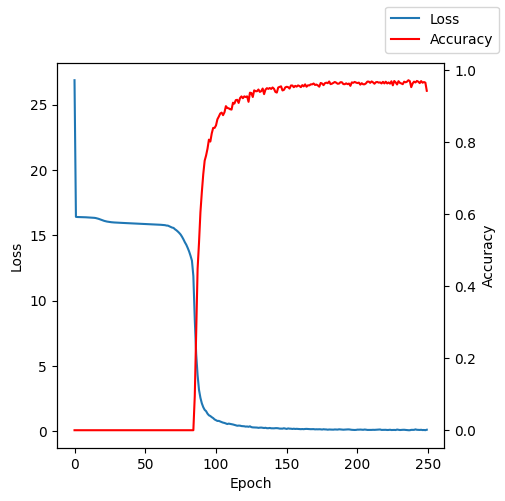

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(loss_array, label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

axs = ax.twinx()
axs.plot(acc_array, label="Accuracy", color="red")
axs.set_ylabel("Accuracy")
fig.legend()
plt.show()

In [55]:
# Eval Clean
datadir = os.path.join(*[os.getcwd(), "train", "data"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=256, shuffle=False)
predict, gt, imgs = eval(cap_noise, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.9889834752128193


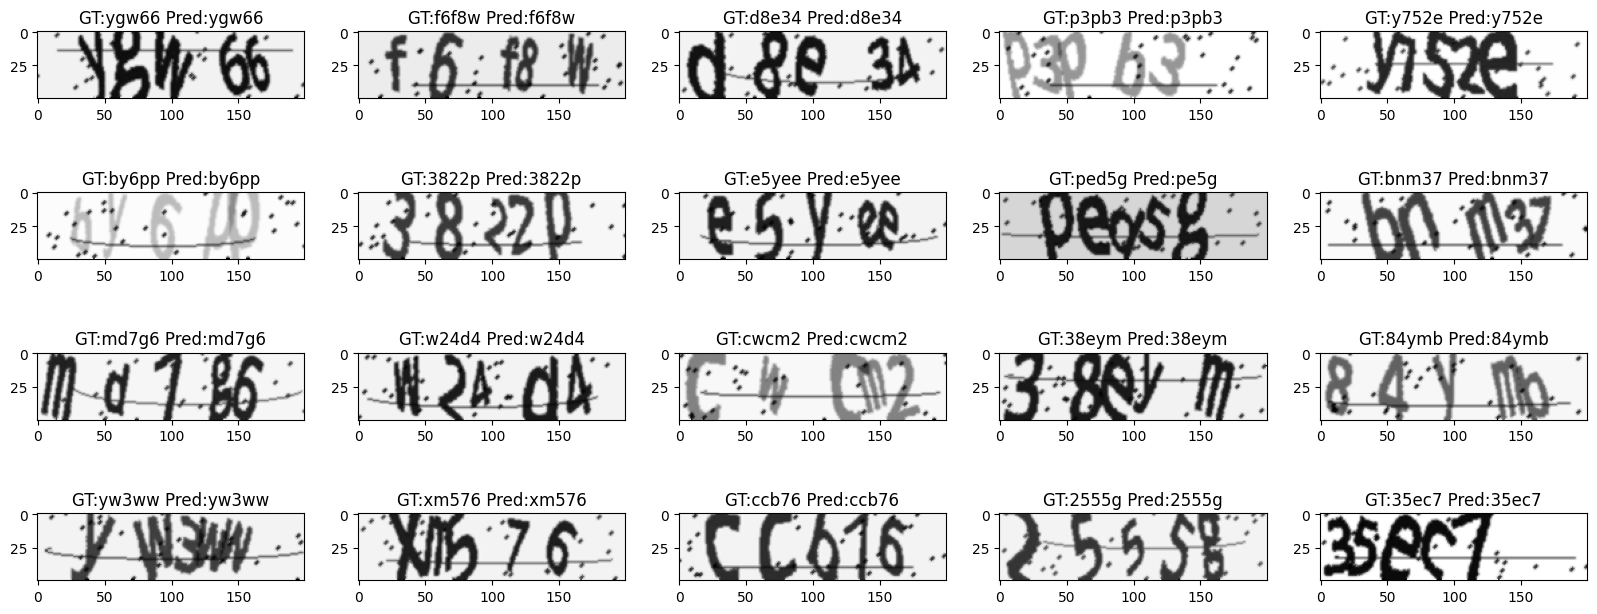

In [60]:
fig, ax = plt.subplots(4, 5, figsize=(20, 8))
for i in range(20):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cap_all = Captcha_Model()
cap_all.load_state_dict(torch.load("captcha_model_captcha_library_10000.pth"))
cap_all.to(device)
cap_all.eval()

Captcha_Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1536, out_features=256, bias=True)
  (gru): GRU(256, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (linear2): Linear(in_features=256, out_features=20, bias=True)
)

In [61]:
# Eval SP 5
datadir = os.path.join(*[os.getcwd(), "data_noisy", "sp_samples_a05"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap_noise, dataloader_test)
print(len(predict))
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

1997
Accuracy:  0.9589384076114171


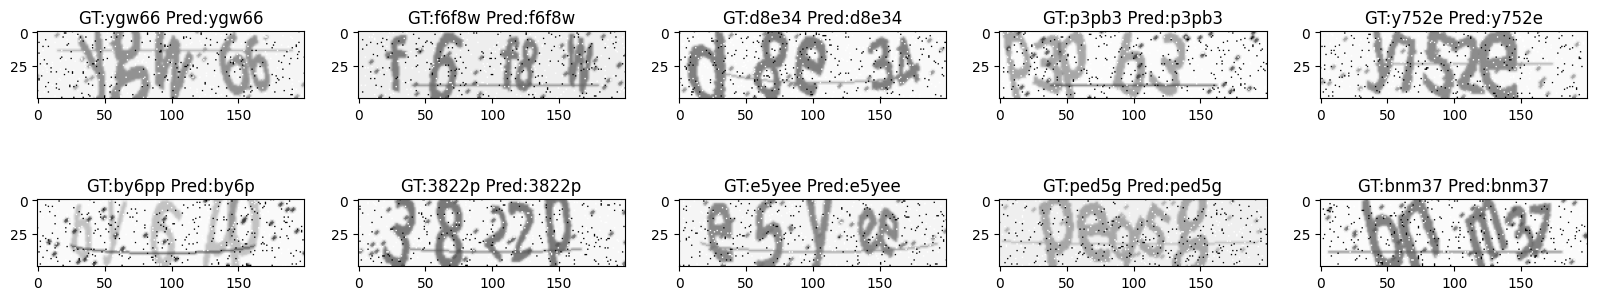

In [62]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(10):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")

In [64]:
# Eval Gauss 1
datadir = os.path.join(*[os.getcwd(), "data_noisy", "gauss_samples_m0_v01"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap_noise, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.9394091136705057


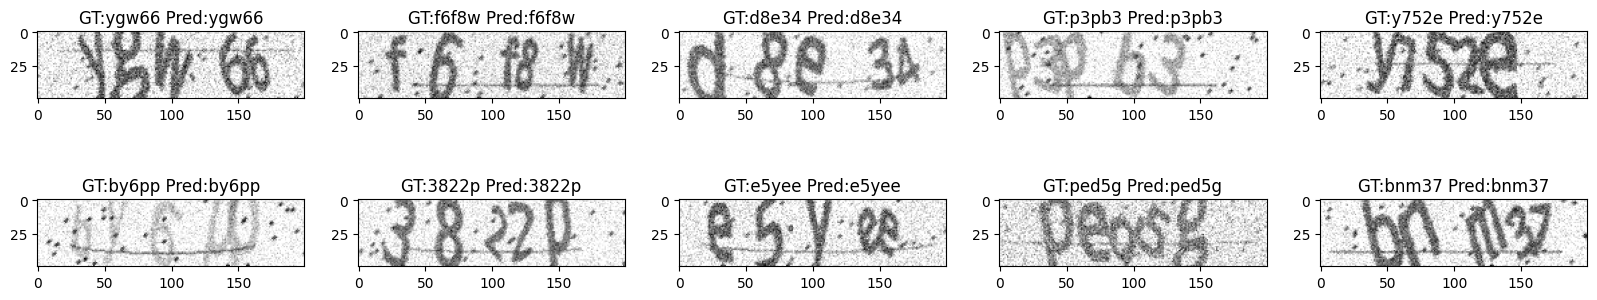

In [65]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(10):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")

In [66]:
# Eval Gauss 10
datadir = os.path.join(*[os.getcwd(), "data_noisy", "gauss_samples_m0_v10"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap_noise, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.8072108162243365


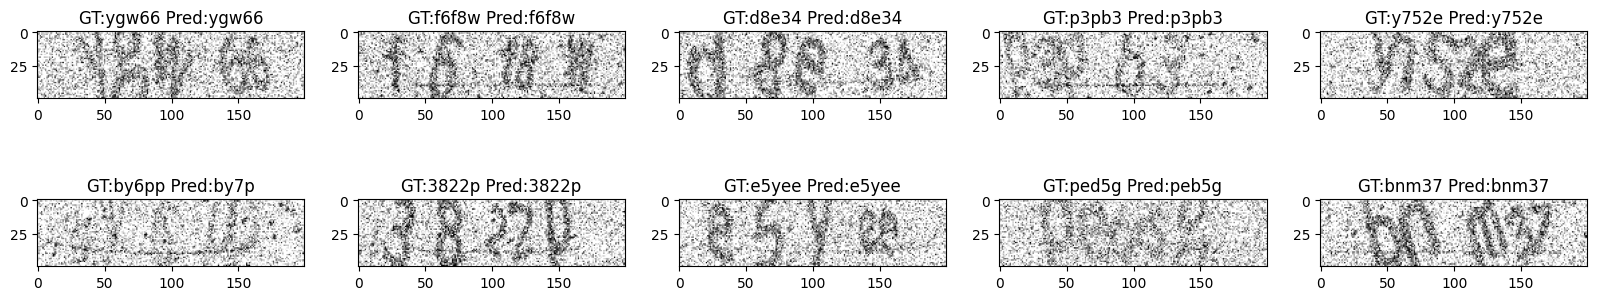

In [67]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(10):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")

In [68]:
# Eval Sp 20
datadir = os.path.join(*[os.getcwd(), "data_noisy", "sp_samples_a20"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
predict, gt, imgs = eval(cap_noise, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.9589384076114171


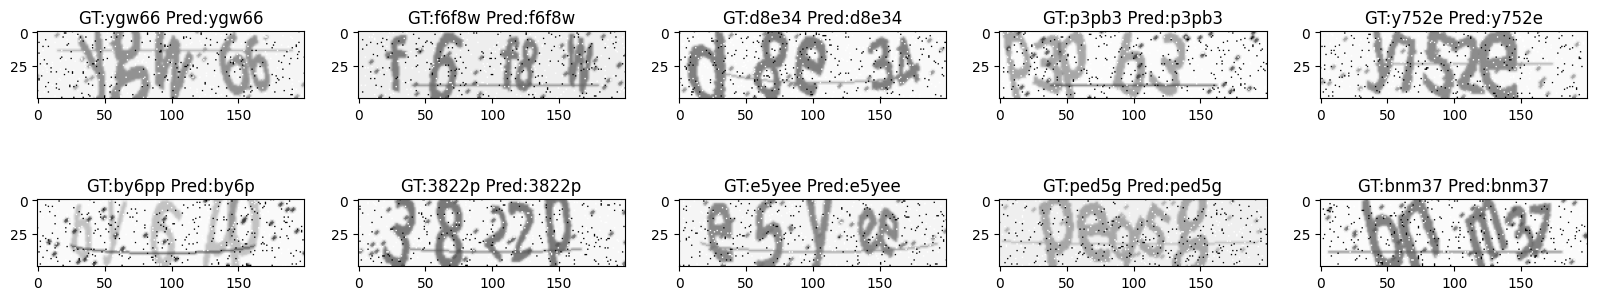

In [69]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(10):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")